# Exploartory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import os, sys
import zipfile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Path to the zip file in Google Drive
zip_path = '/content/gdrive/MyDrive/raw_analyst_ratings.csv.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get a list of all the files in the zip archive
    file_list = zip_ref.namelist()

    # Loop through the files and read each CSV file into a DataFrame
    dfs = {}
    for file in file_list:
        if file.endswith('.csv'):
            zip_ref.extract(file)
            # Use the string '%Y-%m-%d %H:%M' directly for the date_format
            df = pd.read_csv(file)
            dfs[file.split('.')[0]] = df


# Access the DataFrames
print(dfs.keys())  # Print the names of the DataFrames

# save csv
for filename, df in dfs.items():
  df.to_csv(f'{filename}.csv', index=False)


dict_keys(['raw_analyst_ratings'])


In [3]:
# Load data
news = pd.read_csv('../data/raw/raw_analyst_ratings.csv')
#news = pd.read_csv('/content/raw_analyst_ratings.csv')

### Descriptive Statistics

In [5]:
news.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
news = news.drop('Unnamed: 0', axis=1)

In [4]:
news.columns

Index(['headline', 'url', 'publisher', 'date', 'stock'], dtype='object')

In [ ]:
news.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [ ]:
news.dtypes

headline     object
url          object
publisher    object
date         object
stock        object
dtype: object

In [5]:
news['date'] = pd.to_datetime(news['date'], format= 'ISO8601', utc=True)

In [6]:
news.dtypes

headline                  object
url                       object
publisher                 object
date         datetime64[ns, UTC]
stock                     object
dtype: object

In [8]:
news.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A


In [ ]:
news.shape

(1407328, 5)

In [58]:
# Get unique stocks using unique()
unique_stocks = news['stock'].unique()
print("Unique stocks:", len(unique_stocks))

Unique stocks: 6204


- Headline Length

In [ ]:
news['word_count'] = news['headline'].apply(lambda x: len(x.split()))
total_headlines = news.shape[0]
print('total headlines: ', total_headlines)
unique_dates = news['date'].nunique()
print('unique dates: ', unique_dates)

total headlines:  1407328
unique dates:  39957


In [ ]:
# minimum word on headlines
min_words = news['word_count'].min()
print('minimum words on headline: ', min_words)

minimum words on headline:  1


In [ ]:
min_word_count_rows = news[news['word_count'] == 1]
min_word_count_rows
min_word_count_indices = news.index[news['word_count'] == 1].tolist()
min_num = len(min_word_count_indices)
print('Number of publishers with minimum nuber of headlines:', min_num)

Number of publishers with minimum nuber of headlines: 59


In [ ]:
# maximum word on headlines
max_words = news['word_count'].max()
print('maximum words on headline: ', max_words)

maximum words on headline:  77


In [ ]:
# Average headline length
average_word_count = news['word_count'].mean()
average_word_count

11.416705984674504

In [ ]:
# Get rows with maximum word count
max_word_count_rows = news[news['word_count'] == news['word_count'].max()]

# Display the full headlines
print(max_word_count_rows.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                headline                                                                                                                                                url      publisher                      date stock  word_count
701748  JinkoSolar Tiger Pro Series Receives World's First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in 

- Number of articles per publisher

In [ ]:

articles_per_publisher = news.groupby('publisher').size().reset_index(name='headline_count')

# Display the result
print(articles_per_publisher)


                       publisher  article_count
0                     47ertrends             18
1                           AARP              7
2                    ABNNewswire             13
3                          Aakin              5
4               Aaron Jackson.Ed             16
...                          ...            ...
1029  vic@forextraininggroup.com              1
1030     vishwanath@benzinga.com           1830
1031   vivek.proactive@gmail.com            120
1032              wallstreet1928              8
1033                   webmaster          20313

[1034 rows x 2 columns]


publisher        object
article_count     int64
dtype: object

In [ ]:
len(articles_per_publisher)

1034

In [ ]:
#  Sorting in ascending order
sorted_publishers = articles_per_publisher.sort_values(by='article_count', ascending=True)
sorted_publishers.tail()

,publisher,article_count
622,Monica Gerson,82380
169,Charles Gross,96732
96,Benzinga Newsdesk,150484
532,Lisa Levin,186979
686,Paul Quintaro,228373


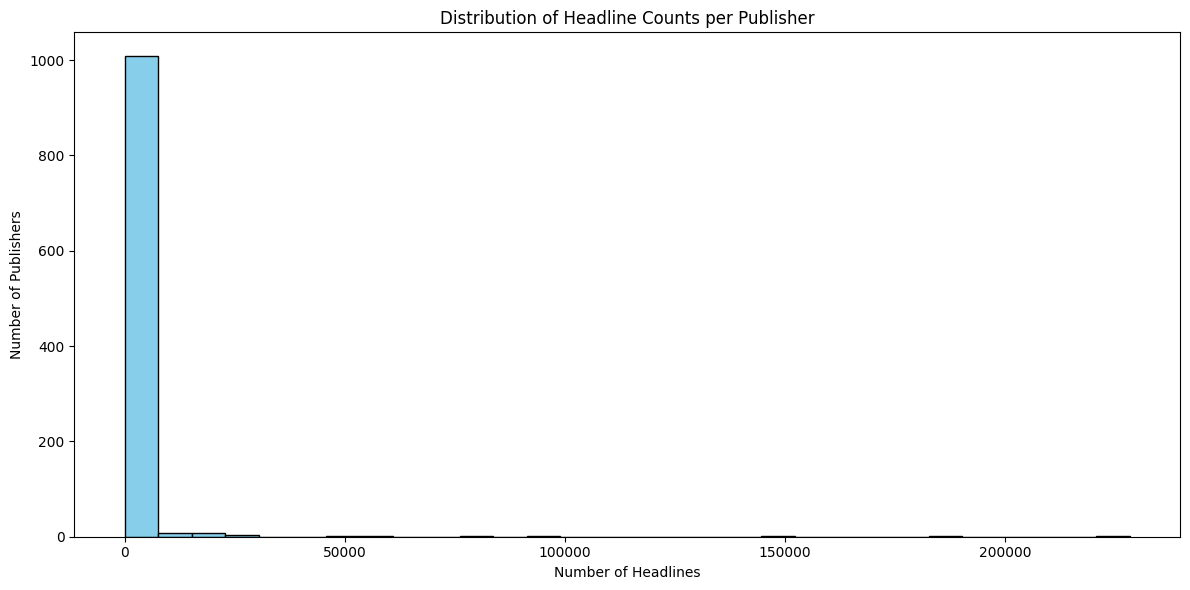

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(articles_per_publisher['headline_count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Headlines')
plt.ylabel('Number of Publishers')
plt.title('Distribution of Headline Counts per Publisher')
plt.tight_layout()
plt.show()

### Trend

In [31]:
daily_counts = news.groupby(news['date'].dt.date).size()
daily_counts.tail()

date
2020-06-07     25
2020-06-08    765
2020-06-09    803
2020-06-10    807
2020-06-11    544
dtype: int64

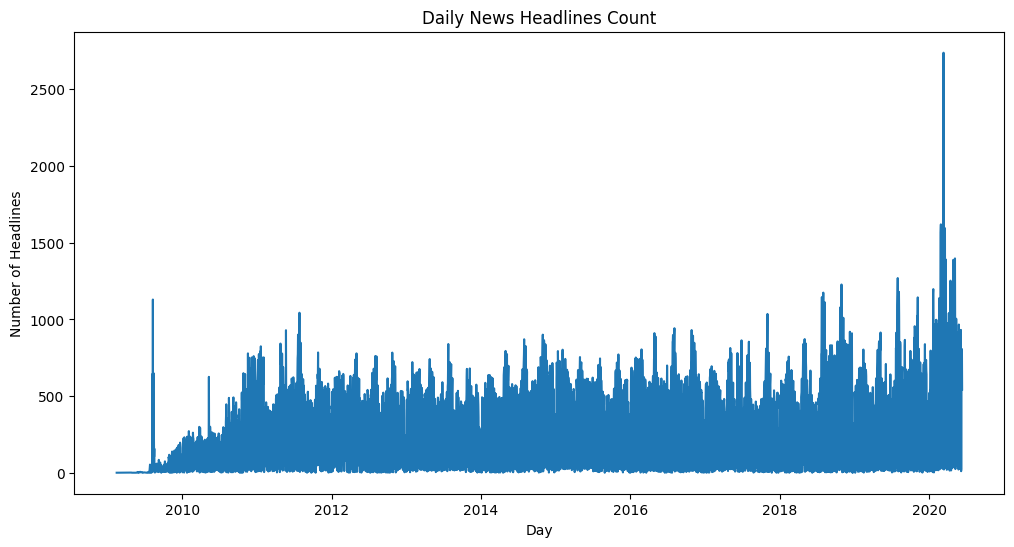

In [ ]:
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Daily News Headlines Count')
plt.xlabel('Day')
plt.ylabel('Number of Headlines')
plt.show()

In [ ]:
#   Daily counts
news['day_of_week'] = news['date'].dt.day_name()
articles_per_day = news.groupby('day_of_week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

C:\Users\Yoseph\AppData\Local\Temp\ipykernel_30908\2400483127.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=articles_per_day.index, y=articles_per_day.values, palette='Blues_d')


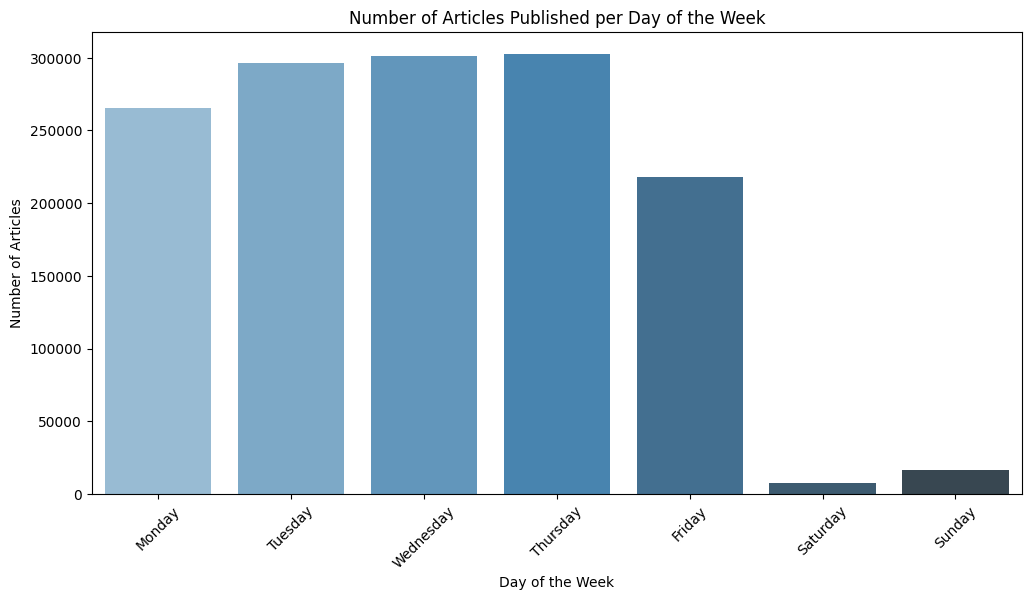

In [ ]:
# Number of articles per day
plt.figure(figsize=(12, 6))
sns.barplot(x=articles_per_day.index, y=articles_per_day.values, palette='Blues_d')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.title('Number of Articles Published per Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [ ]:
monthly_counts = news.resample('ME', on='date').size()
monthly_counts.shape
monthly_counts.head()


date
2009-02-28 00:00:00+00:00     1
2009-03-31 00:00:00+00:00     0
2009-04-30 00:00:00+00:00     3
2009-05-31 00:00:00+00:00    12
2009-06-30 00:00:00+00:00    40
Freq: ME, dtype: int64

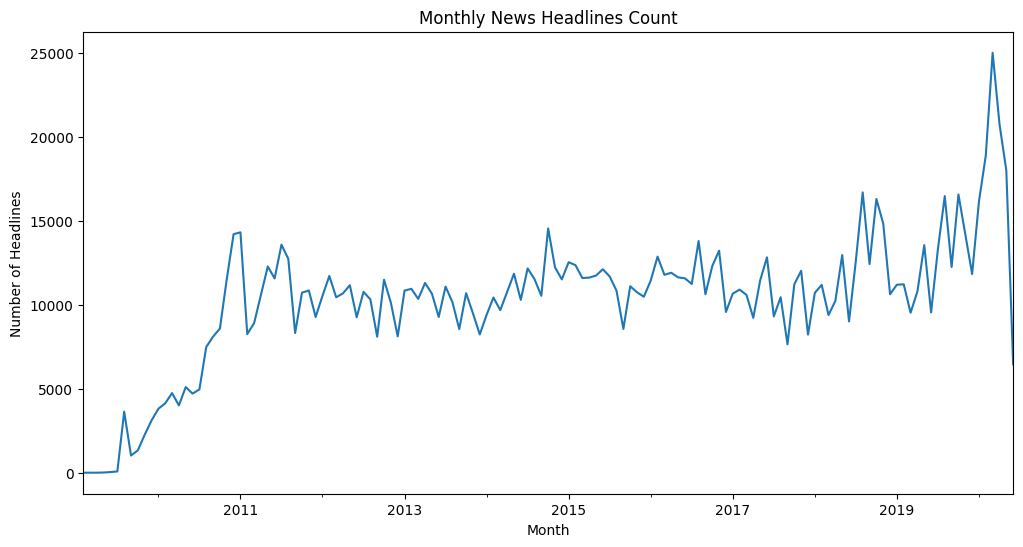

In [ ]:


plt.figure(figsize=(12, 6))
monthly_counts.plot()
plt.title('Monthly News Headlines Count')
plt.xlabel('Month')
plt.ylabel('Number of Headlines')
plt.show()

In [ ]:
yearly_counts = news.resample('YE', on='date').size()
yearly_counts.shape
yearly_counts.head(12)


date
2009-12-31 00:00:00+00:00     11489
2010-12-31 00:00:00+00:00     81319
2011-12-31 00:00:00+00:00    131322
2012-12-31 00:00:00+00:00    122649
2013-12-31 00:00:00+00:00    121529
2014-12-31 00:00:00+00:00    134859
2015-12-31 00:00:00+00:00    135295
2016-12-31 00:00:00+00:00    141892
2017-12-31 00:00:00+00:00    124456
2018-12-31 00:00:00+00:00    146924
2019-12-31 00:00:00+00:00    150380
2020-12-31 00:00:00+00:00    105214
Freq: YE-DEC, dtype: int64

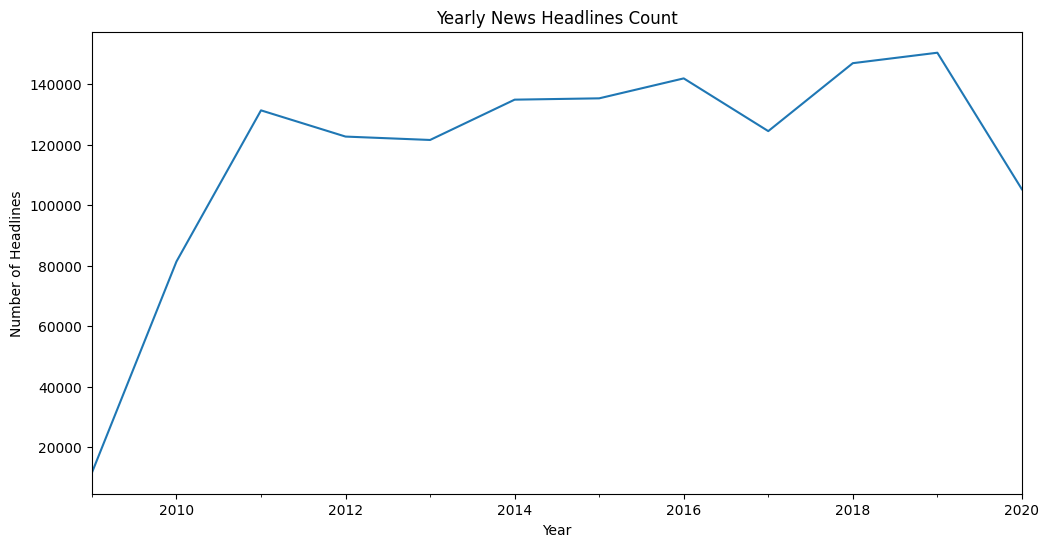

In [ ]:
plt.figure(figsize=(12, 6))
yearly_counts.plot()
plt.title('Yearly News Headlines Count')
plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.show()

In [ ]:
quarterly_counts = news.resample('QE', on='date').size()
quarterly_counts.shape
quarterly_counts.head()


date
2009-03-31 00:00:00+00:00        1
2009-06-30 00:00:00+00:00       55
2009-09-30 00:00:00+00:00     4731
2009-12-31 00:00:00+00:00     6702
2010-03-31 00:00:00+00:00    12676
Freq: QE-DEC, dtype: int64

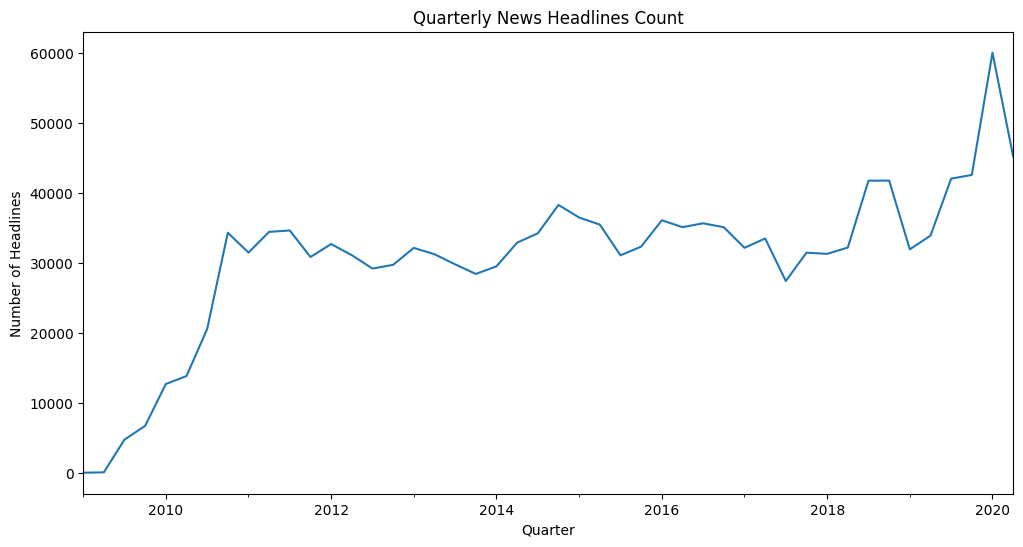

In [ ]:
plt.figure(figsize=(12, 6))
quarterly_counts.plot()
plt.title('Quarterly News Headlines Count')
plt.xlabel('Quarter')
plt.ylabel('Number of Headlines')
plt.show()

### Publisher Analysis

In [ ]:
# Maximum and Minimum number of headlines publishers
# Count the number of headlines per publisher
articles_per_publisher = news.groupby('publisher').size().reset_index(name='headline_count')

# Find the maximum and minimum headline counts
max_headlines = articles_per_publisher['headline_count'].max()
min_headlines = articles_per_publisher['headline_count'].min()

# Get the publishers with max and min counts
max_publishers = articles_per_publisher[articles_per_publisher['headline_count'] == max_headlines]
min_publishers = articles_per_publisher[articles_per_publisher['headline_count'] == min_headlines]

# Display the results
print("Publisher(s) with the maximum number of headlines:")
print(max_publishers)

print("\nPublisher(s) with the minimum number of headlines:")
print(min_publishers)

Publisher(s) with the maximum number of headlines:
         publisher  headline_count
686  Paul Quintaro          228373

Publisher(s) with the minimum number of headlines:
                       publisher  headline_count
15                   Adam Weiner               1
22                   Alex Roslin               1
26               Alexander Voigt               1
33                  Allan Farley               1
36                   Alpha Works               1
...                          ...             ...
1004    official@stockmetrix.net               1
1008                 pagetraffic               1
1012                        phil               1
1023                   swenstock               1
1029  vic@forextraininggroup.com               1

[161 rows x 2 columns]


In [ ]:
# Sort in descending order to find top contributors
top_publishers = articles_per_publisher.sort_values(by='headline_count', ascending=False)

# Display the top publishers
print(top_publishers.head(10))  # Adjust the number as needed

             publisher  headline_count
686      Paul Quintaro          228373
532         Lisa Levin          186979
96   Benzinga Newsdesk          150484
169      Charles Gross           96732
622      Monica Gerson           82380
275       Eddie Staley           57254
353         Hal Lindon           49047
270      ETF Professor           28489
478         Juan Lopez           28438
98      Benzinga Staff           28114


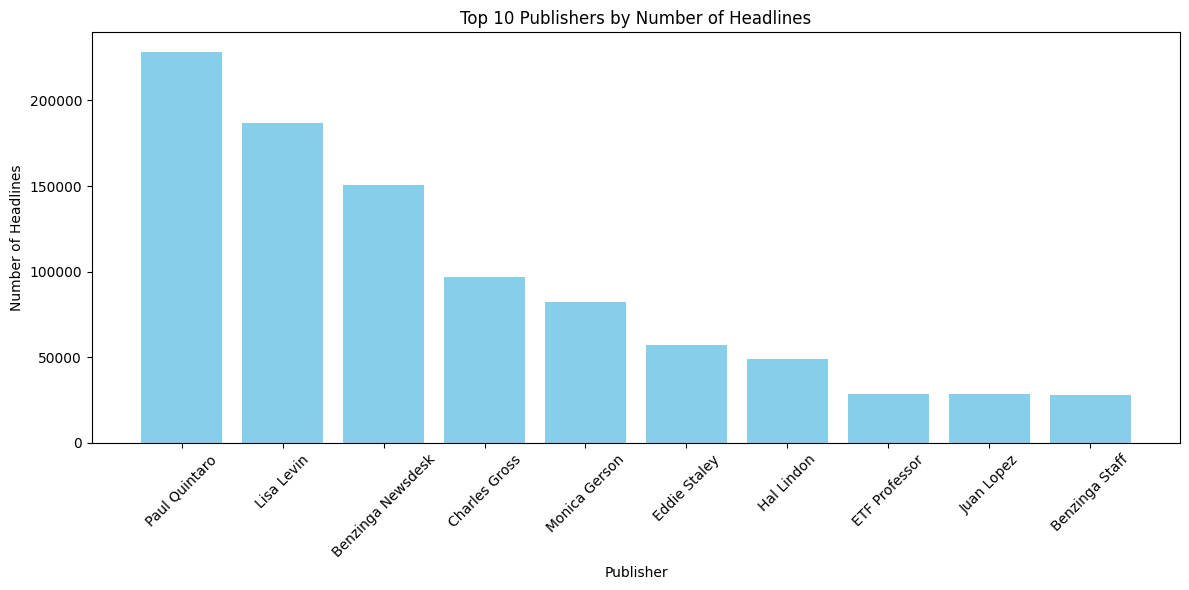

In [ ]:
# the top 10 publishers
top_n = articles_per_publisher.nlargest(10, 'headline_count')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(top_n['publisher'], top_n['headline_count'], color='skyblue')
plt.xlabel('Publisher')
plt.ylabel('Number of Headlines')
plt.title('Top 10 Publishers by Number of Headlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sentiment Analysis

In [ ]:
all_words = ' '.join(news['headline']).split()
#stop_words =
common_words = Counter(all_words).most_common(20)
common_words

[('to', 278059),
 ('of', 200237),
 ('Stocks', 155196),
 ('For', 154330),
 ('on', 143732),
 ('vs', 130104),
 ('In', 129558),
 ('EPS', 127298),
 ('To', 124268),
 ('The', 120684),
 ('Reports', 107394),
 ('On', 100424),
 ('Shares', 97694),
 ('in', 89981),
 ('the', 89228),
 ('for', 84003),
 ('Market', 82475),
 ('Earnings', 78837),
 ('Top', 77783),
 ('Sales', 72879)]

In [6]:
news['sentiment'] = news['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_trend = news.groupby(news['date'].dt.date)['sentiment'].mean()

In [12]:
sentiment_trend

,sentiment
date,
2009-02-14,0.000000
2009-04-27,0.000000
2009-04-29,0.000000
2009-05-22,0.000000
2009-05-27,0.234091
...,...
2020-06-07,0.034242
2020-06-08,0.059971
2020-06-09,0.018360


In [11]:
news.head()

,headline,url,publisher,date,stock,sentiment
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,0.0
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,0.0
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,0.0


In [7]:
sentiment_data = news.copy()

In [8]:
sentiment_data['sentiment_category'] = pd.cut(sentiment_data['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])
sentiment_data.head()


,headline,url,publisher,date,stock,sentiment,sentiment_category
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,0.0,Neutral
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,0.0,Neutral
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,0.0,Neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,0.0,Neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,0.0,Neutral


In [11]:
category_counts = sentiment_data['sentiment_category'].value_counts()
category_counts

sentiment_category
Neutral     1038528
Positive     269878
Negative      96445
Name: count, dtype: int64

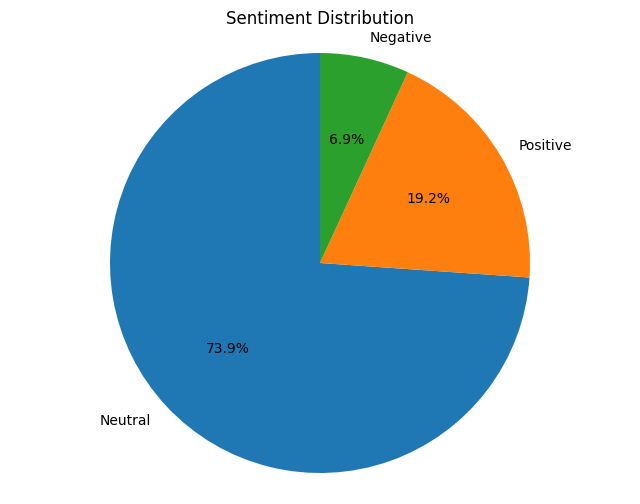

In [17]:
# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

- Topic Analysis

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Combine all headlines into a single string
all_headlines = ' '.join(news["headline"].astype(str).tolist())

# Tokenize the text
tokens = word_tokenize(all_headlines.lower())

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

In [8]:
freq_dist = FreqDist(filtered_tokens)

In [11]:
# Get the 20 most common words
common_topics = freq_dist.most_common(20)
print(common_topics)

[('stocks', 161702), ('vs', 138833), ('eps', 128801), ('est', 122289), ('shares', 114140), ('reports', 108688), ('update', 91645), ('market', 91080), ('earnings', 87183), ('sales', 79528), ('top', 78493), ('benzinga', 74466), ('pt', 73059), ('announces', 66531), ('price', 64217), ('buy', 63927), ('downgrades', 61942), ('trading', 61146), ('raises', 57793), ('upgrades', 56802)]


###  data preprocessing for task-3

In [9]:
df_filter = sentiment_data[['headline', 'date', 'stock', 'sentiment']].copy()
df_filter.head()

,headline,date,stock,sentiment
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 14:30:54+00:00,A,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 14:45:20+00:00,A,0.0
2,71 Biggest Movers From Friday,2020-05-26 08:30:07+00:00,A,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 16:45:06+00:00,A,0.0
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 15:38:59+00:00,A,0.0


In [10]:
df_filter['Date'] = df_filter['date'].dt.date
df_filter = df_filter.drop(columns=['date'])
df_filter.head()

,headline,stock,sentiment,Date
0,Stocks That Hit 52-Week Highs On Friday,A,0.0,2020-06-05
1,Stocks That Hit 52-Week Highs On Wednesday,A,0.0,2020-06-03
2,71 Biggest Movers From Friday,A,0.0,2020-05-26
3,46 Stocks Moving In Friday's Mid-Day Session,A,0.0,2020-05-22
4,B of A Securities Maintains Neutral on Agilent...,A,0.0,2020-05-22


In [11]:
df_sorted = df_filter.sort_values(by=['stock', 'Date'])
print(df_sorted.shape)
df_sorted.head()

(1407328, 4)


,headline,stock,sentiment,Date
1432,Going Against the Herd,A,0.0,2009-04-29
1431,super-trades - Two 52 week highs and others ab...,A,0.0,2009-06-01
1430,Skystar Bio-Pharmaceutical Announces Expansion...,A,0.0,2009-07-14
1429,The Gold/Silver Ratio From 1300 to 1900...And Now,A,0.0,2009-07-30
1428,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",A,0.0,2009-08-04


In [12]:
stocks_to_keep = ['GOOG', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NVDA' ]
filtered_df = df_sorted[df_sorted['stock'].isin(stocks_to_keep)]


In [13]:
filtered_df.tail()

,headline,stock,sentiment,Date
1255226,Tesla Shares Mark Session And New All-Time Hig...,TSLA,0.148182,2020-06-10
1255227,Wedbush Says Tesla Has 'Game Changing' Develop...,TSLA,-0.400000,2020-06-10
1255228,"Wedbush Maintains Neutral on Tesla, Raises Pri...",TSLA,0.000000,2020-06-10
1255229,Musk Says It's Time To Ramp Production Of Tesl...,TSLA,0.000000,2020-06-10
1255230,Tesla shares are trading higher after Wedbush ...,TSLA,0.250000,2020-06-10


In [15]:
average_sentiment = filtered_df.groupby(['Date', 'stock'])['sentiment'].mean().reset_index()
sorted_df = average_sentiment.sort_values(by=['stock', 'Date'])
print(sorted_df.shape)


(1975, 3)


In [16]:
sorted_df.tail()

,Date,stock,sentiment
1948,2020-05-30,TSLA,0.083333
1952,2020-05-31,TSLA,0.000000
1956,2020-06-01,TSLA,0.077917
1961,2020-06-02,TSLA,0.161147
1974,2020-06-10,TSLA,0.037515


In [56]:
sorted_df.to_csv('average_sentiment.csv', index=False)